In [8]:

!pip install --upgrade alpaca-py
!python -m pip install requests

In [6]:
pip show alpaca-py

Name: alpaca-py
Version: 0.40.1
Summary: The Official Python SDK for Alpaca APIs
Home-page: 
Author: Rahul Chowdhury
Author-email: rahul.chowdhury@alpaca.markets
License: Apache-2.0
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: msgpack, pandas, pydantic, requests, sseclient-py, websockets
Required-by: 
Note: you may need to restart the kernel to use updated packages.


Enter a company name:  Apple


The ticker for Apple is: AAPL


Enter the expiration date (DD/MM/YYYY):  20/06/2025


2370
AAPL250530C00187500 symbol='AAPL250530C00187500' latest_trade={   'conditions': 'I',
    'exchange': 'D',
    'id': None,
    'price': 10.8,
    'size': 1.0,
    'symbol': 'AAPL250530C00187500',
    'tape': None,
    'timestamp': datetime.datetime(2025, 5, 27, 13, 41, 50, 966851, tzinfo=TzInfo(UTC))} latest_quote={   'ask_exchange': 'X',
    'ask_price': 11.33,
    'ask_size': 73.0,
    'bid_exchange': 'W',
    'bid_price': 11.17,
    'bid_size': 108.0,
    'conditions': ' ',
    'symbol': 'AAPL250530C00187500',
    'tape': None,
    'timestamp': datetime.datetime(2025, 5, 27, 14, 5, 42, 974334, tzinfo=TzInfo(UTC))} implied_volatility=0.4568 greeks={   'delta': 0.9177,
    'gamma': 0.0185,
    'rho': 0.014,
    'theta': -0.2267,
    'vega': 0.0273}
AAPL250530C00192500 symbol='AAPL250530C00192500' latest_trade={   'conditions': 'a',
    'exchange': 'A',
    'id': None,
    'price': 6.53,
    'size': 11.0,
    'symbol': 'AAPL250530C00192500',
    'tape': None,
    'timestamp': datet

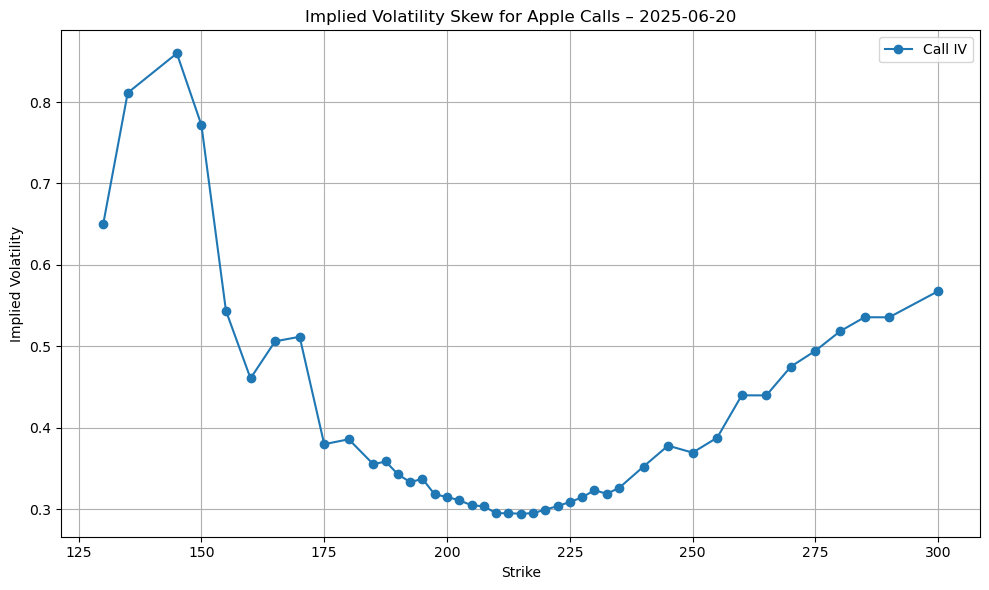

In [82]:
import requests

def get_ticker_from_name(company_name):
    url = f"https://query2.finance.yahoo.com/v1/finance/search?q={company_name}"
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    response = requests.get(url, headers=headers)
    
    # Check for successful response
    if response.status_code != 200:
        print(f"Error: Status code {response.status_code}")
        return None

    try:
        data = response.json()
        if 'quotes' in data and data['quotes']:
            return data['quotes'][0]['symbol']
        else:
            print("No quotes found.")
            return None
    except Exception as e:
        print(f"JSON parsing error: {e}")
        print("Raw response:", response.text[:300])  # Preview what went wrong
        return None

name = input("Enter a company name: ")
ticker = get_ticker_from_name(name)

if ticker:
    print(f"The ticker for {name} is: {ticker}")
else:
    print("Ticker not found.")
type(ticker)

# Input in DD/MM/YYYY format
from datetime import datetime
user_input = input("Enter the expiration date (DD/MM/YYYY): ")

try:
    # Convert the input string to a datetime object
    date_obj = datetime.strptime(user_input, "%d/%m/%Y")

    # Convert it to a pandas Timestamp or keep it as a datetime object
    expiry_date = pd.Timestamp(date_obj)

except ValueError:
    print("Invalid date format. Please use DD/MM/YYYY.")


from alpaca.data.historical import OptionHistoricalDataClient
from alpaca.data.requests import OptionChainRequest
api_key='PKCH9GYKZR9LV4GJBS5K'
secret_key='0Vznk5aTbg705YSvRjlfVzhxFs7phaXJoqLdweQh'
# Initialize the data client (use your API keys)
options_client = OptionHistoricalDataClient(api_key, secret_key)

# Request the latest option chain snapshot for NVDA
chain_request = OptionChainRequest(underlying_symbol=ticker)
optn_chain = options_client.get_option_chain(chain_request)
print(len(optn_chain))
for i, (k, v) in enumerate(optn_chain.items()):
    print(k, v)
    if i >= 3:  
        break

import pandas as pd

def flatten_option_data(option_dict):
    records = []
    for sym, snapshot in option_dict.items():
        row = {
            'symbol': sym,
            'iv': getattr(snapshot, 'implied_volatility', None)
        }

        # latest_quote
        quote = getattr(snapshot, 'latest_quote', None)
        if quote:
            row['bid'] = getattr(quote, 'bid_price', None)
            row['ask'] = getattr(quote, 'ask_price', None)
            row['quote_time'] = getattr(quote, 'timestamp', None)

        # latest_trade
        trade = getattr(snapshot, 'latest_trade', None)
        if trade:
            row['last_price'] = getattr(trade, 'price', None)
            row['last_size'] = getattr(trade, 'size', None)
            row['trade_time'] = getattr(trade, 'timestamp', None)

        # greeks
        greeks = getattr(snapshot, 'greeks', None)
        if greeks:
            row['delta'] = getattr(greeks, 'delta', None)
            row['gamma'] = getattr(greeks, 'gamma', None)
            row['vega']  = getattr(greeks, 'vega', None)
            row['theta'] = getattr(greeks, 'theta', None)
            row['rho']   = getattr(greeks, 'rho', None)

        records.append(row)

    return pd.DataFrame(records)
df_options = flatten_option_data(optn_chain).dropna()


# Extract expiration date and strike from symbol
import re

import pandas as pd

def parse_symbol(symbol):
    # The last 15 characters are: YYMMDD + C/P + 8-digit strike
    date_str = symbol[-15:-9]
    opt_type = symbol[-9]
    strike_str = symbol[-8:]

    # Convert date
    year = int('20' + date_str[:2])
    month = int(date_str[2:4])
    day = int(date_str[4:6])
    expiry = pd.Timestamp(year=year, month=month, day=day)

    # Convert strike
    strike = int(strike_str) / 1000

    # Everything before that is the underlying
    underlying = symbol[:-15]

    return underlying, expiry, opt_type, strike

# Apply to dataframe
df_options[['underlying', 'expiry', 'option_type', 'strike']] = df_options['symbol'].apply(lambda s: pd.Series(parse_symbol(s)))


target_date = pd.Timestamp(expiry_date)
option_type = "C"
df_filtered = df_options[(df_options['expiry'] == target_date)&(df_options['option_type'] == option_type)].copy()


# If no exact match found, fallback to closest later expiry
if df_filtered.empty:
    print("❌ No options found for that exact maturity. Looking for the next available expiry...")

    # Filter only later dates of same option type
    future_expiries = df_options[
        (df_options['expiry'] > target_date) &
        (df_options['option_type'] == option_type)
    ]['expiry'].unique()

    if len(future_expiries) == 0:
        raise ValueError("❌ No later maturities found for the selected option type.")

    # Find the closest later expiry
    closest_later_date = min(future_expiries)

    print(f"✅ Using closest later expiry: {closest_later_date.date()}")

    # Refilter the DataFrame using the new date
    target_date = closest_later_date
    df_filtered = df_options[
        (df_options['expiry'] == target_date) & 
        (df_options['option_type'] == option_type)
    ].copy()

import matplotlib.pyplot as plt

# Compute mid prices for reference 
df_filtered['mid_price'] = (df_filtered['bid'] + df_filtered['ask']) / 2

# Sort by strike
df_filtered = df_filtered.sort_values('strike')
print (df_filtered[['symbol','expiry','strike', 'iv']])
# Plot the skew
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['strike'], df_filtered['iv'], 'o-', label='Call IV')
plt.title(f'Implied Volatility Skew for {name} Calls – {target_date.date()}')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

